In [335]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#from scipy.interpolate import interp1d

def larmor_radius(KE, B, charge_mass_ratio = 9.58e7, charge_in_e = 1):
    c = 3e8
    q = (1.6e-19)*charge_in_e
    m = q/charge_mass_ratio
    E = KE+m*9e16
    p = (1/c)*np.sqrt((E**2)-((m**2)*(c**4)))
    R = p/(q*B)
    return R

def track_particle_2D(
        #input everything in SI units, except for E being in eV
        #B is in the Z direction for the 2D tracker
        Energy_eV,
        B_data = np.array([1]),
        B_axes = np.array([0]),
        theta_0 = 0,
        theta_z = 0,
        d_tcc = 0.5,
        delta_d = 0.0005,
        nonuniform_B = True,
        uniform_B = 1,
        charge_mass_ratio = 9.58e7,
        charge_in_e = 1,
        plate = 'curved',
        IP_radius = 0.20,
        IP_center = np.array([0.10,-0.10]),
        x_max = 1,
        y_max = 1,
        dynamic_step = 1,
        fine_adjustment = 16):
    #initializing variables
    E = (Energy_eV * 1.6e-19)
    x_array = []
    y_array = []
    z_array = []
    x = 0
    y = d_tcc*math.sin(theta_0)*math.cos(theta_z)
    z = d_tcc*math.sin(theta_z)
    theta = theta_0
    x_array.append(x)
    y_array.append(y)
    z_array.append(z)

    if dynamic_step < 1:
        grad_B_data = np.gradient(B_data,B_axes)
        grad_B_max = np.max(grad_B_data)
        delta_D = delta_d

#code block for curved plate
    if plate == 'curved':
        while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < (IP_radius-2*delta_d)**2) and -0.05 < x < 1 and y < 1:
            #find the B field at the particle position
            if nonuniform_B == True:
                #adjust B field given a straight trajectory, take the B field nearer the midpoint of travel
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    #grad_B_adj has a minimum value of 1
                    #grad_B_adj increases to a maximum value of dynamic_step
                    #grad_B_adj determines h0w many times the step is reduced by
                    #dynamic_step determines the maximum value of grad_B_adj
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B
            
            #find the larmor radius of the particle. If the particle has some z-momentum, the energy has a smaller 'effective energy' in the perpendicular direction
            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)
            
            #the distance traveled in the perp direction
            delta_theta_adjusted = delta_d*math.cos(theta_z)/R
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            #the distance traveled in the par direction
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)

        while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < IP_radius**2) and -0.05 < x < 1 and y < 1:
            if nonuniform_B == True:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B

            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)

            delta_theta_adjusted = delta_d*math.cos(theta_z)/(R*fine_adjustment)
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)
            
# code block for flat plate
    if plate == 'flat':
        while 0 < x < x_max-delta_d and y < y_max-delta_d:
            if nonuniform_B == True:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B
            
            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)
            
            delta_theta_adjusted = delta_d*math.cos(theta_z)/R
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)

        while 0 < x < x_max and y < y_max:
            if nonuniform_B == True:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B

            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)

            delta_theta_adjusted = delta_d*math.cos(theta_z)/(R*fine_adjustment)
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)
            
    return np.array(x_array), np.array(y_array), np.array(z_array)




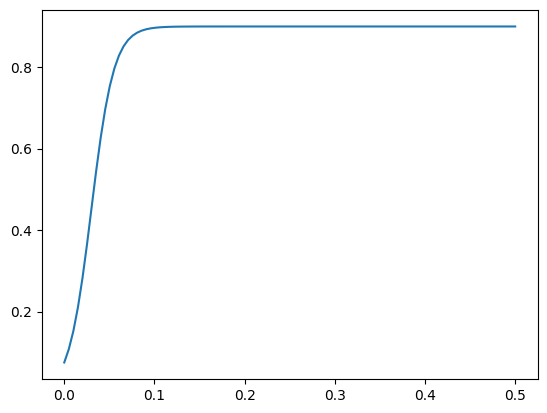

In [336]:
Baxes = np.linspace(0,0.5,100)
#Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.05)))
Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.030)))

IPradius = 0.14
IPcenter = np.array([0.06,-0.12])

E = 2750

solidangle = 0.002
N_particles = 51
thetarange = math.pi*np.linspace(-solidangle,solidangle,N_particles)

plt.plot(Baxes,Bdata)

-0.6409829640286238


(-0.03, 0.03)

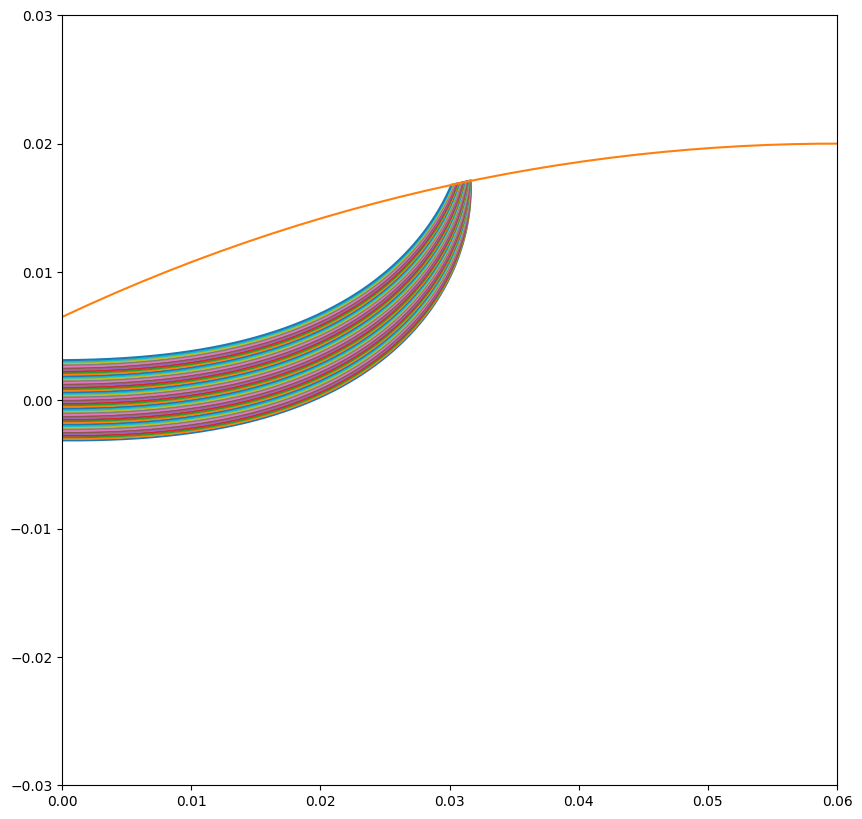

In [337]:
plt.figure(figsize = (10,10))

X_data = []
Y_data = []

for theta in thetarange:
    X, Y, Z = track_particle_2D(
        E,
        B_data = Bdata,
        B_axes = Baxes,
        theta_0 = theta,
        theta_z = (1/32)*math.pi,
        d_tcc = 0.5,
        delta_d = 0.000025,
        nonuniform_B = True,
        uniform_B = 1,
        charge_mass_ratio = 9.58e7,
        charge_in_e = 1,
        plate = 'curved',
        IP_radius = IPradius,
        IP_center = IPcenter,
        )

    plt.plot(X,Y)
    X_data.append(X[-1])
    Y_data.append(Y[-1])

XIP_data = np.array(X_data-IPcenter[0])
YIP_data = np.array(Y_data-IPcenter[1])

#rotate axes to calculate angle from start of IP
theta_0_IP = -math.pi + math.atan(np.sqrt(IPradius**2-(IPcenter[0])**2)/IPcenter[0])
print(theta_0_IP/math.pi)
Xprime = math.cos(theta_0_IP)*XIP_data-math.sin(theta_0_IP)*YIP_data
Yprime = math.sin(theta_0_IP)*XIP_data+math.cos(theta_0_IP)*YIP_data

#using atan to find angle from start of IP
theta_IP_prime = np.zeros(len(Yprime)) 
for i in range(len(Yprime)):
    theta_IP_prime[i] = -math.atan(Yprime[i]/Xprime[i])

#now we can find the distance along the IP
IP_dist_val = theta_IP_prime*IPradius
#print(IP_dist_val)
#IP_reading_val = np.array(sorted(IP_dist_val))
#print(IP_reading_val)

#now we find the average distance between particles on the IP
interpart_dist = np.zeros(len(IP_dist_val))
interpart_dist[0] = 2*(np.abs(IP_dist_val[1]-IP_dist_val[0]))
interpart_dist[-1] = 2*(np.abs(IP_dist_val[-1]-IP_dist_val[-2]))
for i in range(len(IP_dist_val)-2):
    interpart_dist[i+1] = np.abs(IP_dist_val[i+2]-IP_dist_val[i+1])+np.abs(IP_dist_val[i+1]-IP_dist_val[i+0])


#the particle density is just the inverse of the interparticle spacing
particle_dens = 1/interpart_dist

IP_x = np.linspace(0,0.20,100)
IP_y = IPcenter[1]+np.sqrt(IPradius**2-(IP_x-IPcenter[0])**2)
plt.plot(IP_x,IP_y)

plt.xlim(0,0.06)
plt.ylim(-0.03,0.03)

#plt.xlim(0.02-0.005,0.02+0.005)
#plt.ylim(0.013-0.005,0.013+0.005)

#plt.xlim(0.03-0.005,0.03+0.005)
#plt.ylim(0.013-0.005,0.013+0.005)

0
50
Normal incidence IP position: 0.033088306787529005


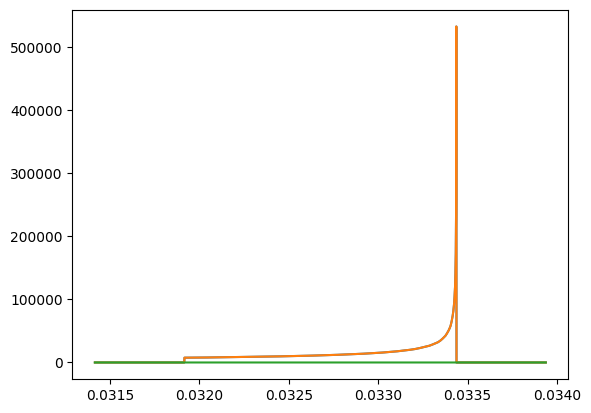

In [294]:
max = np.max(IP_dist_val)
for i in range(len(IP_dist_val)):
    if IP_dist_val[i] == max:
        max_index = i
print(max_index)
print(len(IP_dist_val)-1)
print('Normal incidence IP position:',IP_dist_val[int(0.5*len(IP_dist_val))])

if max_index == 0:
    interpart_dist_a = np.zeros(len(IP_dist_val))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_val[1]-IP_dist_val[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_val[-1]-IP_dist_val[-2]))
    
    for i in range(len(IP_dist_val)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_val[i+2]-IP_dist_val[i+1])+np.abs(IP_dist_val[i+1]-IP_dist_val[i+0])
    
    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_val), np.flip(interpart_dist_a), left=1e7, right=1e7)

    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 0*IP_linspace
    Particle_Density = 1/interp_interpart_a
elif 2 < max_index < ((len(IP_dist_val))-3):

    IP_dist_a = IP_dist_val[:max_index+1]
    IP_dist_b = IP_dist_val[max_index+1:]

    interpart_dist_a = np.zeros(len(IP_dist_a))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
    for i in range(len(IP_dist_a)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

    interpart_dist_b = np.zeros(len(IP_dist_b))
    interpart_dist_b[0] = 2*(np.abs(IP_dist_b[1]-IP_dist_b[0]))
    interpart_dist_b[-1] = 2*(np.abs(IP_dist_b[-1]-IP_dist_b[-2]))
    for i in range(len(IP_dist_b)-2):
        interpart_dist_b[i+1] = np.abs(IP_dist_b[i+2]-IP_dist_b[i+1])+np.abs(IP_dist_b[i+1]-IP_dist_b[i+0])

    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
    interp_interpart_b = np.interp(IP_linspace, np.flip(IP_dist_b), np.flip(interpart_dist_b), left=1e7, right=1e7)

    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 1/interp_interpart_b
    Particle_Density = 1/interp_interpart_a + 1/interp_interpart_b
elif max_index < 3:
    IP_dist_a = IP_dist_val[max_index:]
    
    interpart_dist_a = np.zeros(len(IP_dist_a))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
    for i in range(len(IP_dist_a)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_a), np.flip(interpart_dist_a), left=1e7, right=1e7)
    
    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 0*IP_linspace
    Particle_Density = 1/interp_interpart_a
else:
    IP_dist_a = IP_dist_val[:max_index+1]
    
    interpart_dist_a = np.zeros(len(IP_dist_a))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
    for i in range(len(IP_dist_a)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
    
    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 0*IP_linspace
    Particle_Density = 1/interp_interpart_a

plt.plot(IP_linspace, Particle_Density)
plt.plot(IP_linspace, Particle_Density_a)
plt.plot(IP_linspace, Particle_Density_b)

#plt.xlim(np.min(IP_dist_b)-0.0001,np.max(IP_dist_b)+0.0001)

51
0.020139575398803178
0.0001903995547630176


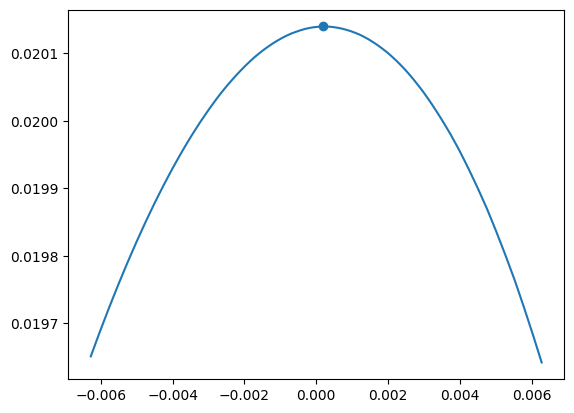

In [274]:
theta_fine = np.linspace(thetarange[0],thetarange[-1],100)
fine_dist_val = np.interp(theta_fine, thetarange, IP_dist_val)
plt.plot(theta_fine,fine_dist_val)
max = np.max(fine_dist_val)
for i in range(len(fine_dist_val)):
    if fine_dist_val[i] == max:
        max_index = i
print(max_index)
print(max)
print(theta_fine[max_index])
plt.scatter(theta_fine[max_index],max)



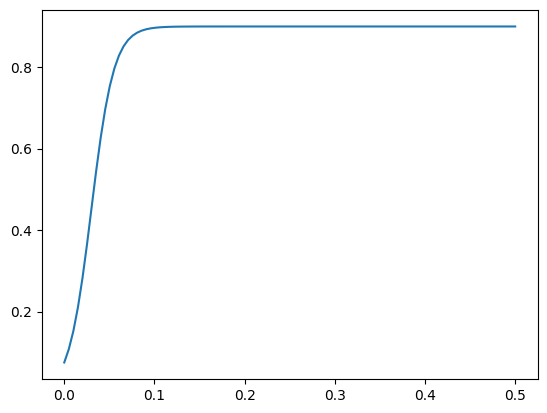

In [321]:
Baxes = np.linspace(0,0.5,100)
#Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.05)))
Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.030)))

IPradius = 0.14
IPcenter = np.array([0.06,-0.12])

E = 50000

solidangle = 0.002
N_particles = 51
thetarange = math.pi*np.linspace(-solidangle,solidangle,N_particles)

plt.plot(Baxes,Bdata)

len_n = 17
len_m = 17
target array shape = (19, 19)
-0.6409829640286238
number of particles = 213


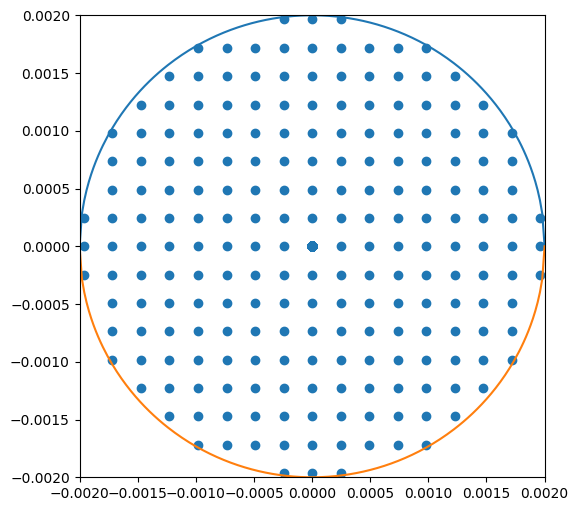

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))

def init_circ_slit(dtcc, r, deltatheta):
    m_max = math.floor((1/deltatheta)*math.atan(r/dtcc))
    m_min = -m_max
    #m is the y index; n is the z index
    mspace = np.linspace(m_min,m_max,m_max-m_min+1)
    narray = []
    for m in mspace:
        y_m = dtcc*math.tan(m*deltatheta)
        if abs(y_m) > r:
            y_m = (y_m/abs(y_m))*(abs(y_m)-(1e-15))
        z_max = np.sqrt((r**2)-(y_m**2))
        n_max = math.floor((1/deltatheta)*math.atan(z_max*math.cos(m*deltatheta)/dtcc))
        n_min = -n_max
        nspace = np.linspace(n_min,n_max,n_max-n_min+1)
        narray.append(nspace)
    return narray, m_min, m_max

def init_circ_boundary(dtcc, r, deltatheta):
    theta_axis = math.atan(r/dtcc)
    #here we use the LOS as the 'z' axis
    #thet_axis describes the angle from the z axis
    #now we initialize the range of theta values in the x-y plane
    thetarange = np.linspace(0,2*math.pi,int(2*math.pi/deltatheta)+1)
    i = 0
    #from here we change back to the LOS as the x-axis, to match with the other codes
    vy = np.zeros(len(thetarange))
    vz = np.zeros(len(thetarange))
    while i < len(thetarange):
        vy[i] = math.sin(theta_axis)*math.cos(thetarange[i])
        vz[i] = math.sin(theta_axis)*math.sin(thetarange[i])
        i = i+1
    vx = math.cos(theta_axis)
    return vx, vy, vz

#set distance tto tcc and radius
dtcc = 0.5
r = 0.002
#dtcc = 1
#r = 1

deltatheta = (1/32)*0.0050
N, m_min, m_max= init_circ_slit(dtcc,r,deltatheta*math.pi)
min_n = np.zeros(m_max-m_min+1)
max_n = np.zeros(m_max-m_min+1)

#find the global maximum and minimum for n
for i in range(m_max-m_min+1):
    min_n[i] = np.min(N[i])
    max_n[i] = np.max(N[i])
len_m = int(m_max-m_min+1)
MIN_N = np.min(min_n)
MAX_N = np.max(max_n)
len_n = int(MAX_N-MIN_N+1)

print('len_n =',len_n)
print('len_m =',len_m)

target_array_y = np.zeros((len_n+2,len_m+2))
target_array_z = np.zeros((len_n+2,len_m+2))
target_array_true = np.zeros((len_n+2,len_m+2))
area_density_function = np.zeros((len_n+2,len_m+2))

IP_array_r = np.zeros((len_n+2,len_m+2))
IP_array_z = np.zeros((len_n+2,len_m+2))
IP_array_true = np.zeros((len_n+2,len_m+2))
IP_flux_density = np.zeros((len_n+2,len_m+2))

print('target array shape =',np.shape(target_array_y))

vx,vy,vz = init_circ_boundary(dtcc, r, 10*deltatheta*math.pi)

X_data = []
Y_data = []
Z_data = []

#loop for going through each particle
i = 0
n_part = 0
while i < (m_max-m_min+1):
    n_min = np.min(N[i])
    for j in range(0,len(N[i])):
        n = int(N[i][j])
        m = int(i+m_min)
        #m is the y index; n is the z index
        #for k we must find the bottom of each n-list to adjust the indices
        #MIN_N is the global minimum n value in the whole N array
        #we need to ajust the bottom index for each N[i] to ensure that n=0 is at the same k-index for all data points
        k = int(j+(n_min-MIN_N))
        target_array_z[k+1,i+1] = dtcc*math.tan(n*deltatheta*math.pi)*(1/math.cos(m*deltatheta*math.pi))
        target_array_y[k+1,i+1] = dtcc*math.tan(m*deltatheta*math.pi)
        target_array_true[k+1,i+1] = 1

        theta_0 = m*deltatheta*math.pi
        theta_z = n*deltatheta*math.pi
        X, Y, Z = track_particle_2D(
            E,
            B_data = Bdata,
            B_axes = Baxes,
            theta_0 = theta_0,
            theta_z = theta_z,
            d_tcc = dtcc,
            delta_d = 0.000025,
            nonuniform_B = True,
            uniform_B = 1,
            charge_mass_ratio = 9.58e7,
            charge_in_e = 1,
            plate = 'curved',
            IP_radius = IPradius,
            IP_center = IPcenter,
            )
        #plt.plot(X,Y)
        X_data.append(X[-1])
        Y_data.append(Y[-1])
        Z_data.append(Z[-1])

        X_end = X[-1]
        Y_end = Y[-1]
        Z_end = Z[-1]

        XIP = X_end-IPcenter[0]
        YIP = Y_end-IPcenter[1]
        theta_0_IP = -math.pi + math.atan(np.sqrt(IPradius**2-(IPcenter[0])**2)/IPcenter[0])
        Xprime = math.cos(theta_0_IP)*XIP-math.sin(theta_0_IP)*YIP
        Yprime = math.sin(theta_0_IP)*XIP+math.cos(theta_0_IP)*YIP
        theta_IP_prime = -math.atan(Yprime/Xprime)
        IP_dist = theta_IP_prime*IPradius

        IP_array_r[k+1,i+1] = IP_dist
        IP_array_z[k+1,i+1] = Z[-1]
        IP_array_true[k+1,i+1] = 1

        n_part = n_part+1
    i = i+1

XIP_data = np.array(X_data-IPcenter[0])
YIP_data = np.array(Y_data-IPcenter[1])

#rotate axes to calculate angle from start of IP
theta_0_IP = -math.pi + math.atan(np.sqrt(IPradius**2-(IPcenter[0])**2)/IPcenter[0])
print(theta_0_IP/math.pi)
Xprime = math.cos(theta_0_IP)*XIP_data-math.sin(theta_0_IP)*YIP_data
Yprime = math.sin(theta_0_IP)*XIP_data+math.cos(theta_0_IP)*YIP_data

#using atan to find angle from start of IP
theta_IP_prime = np.zeros(len(Yprime)) 
for i in range(len(Yprime)):
    theta_IP_prime[i] = -math.atan(Yprime[i]/Xprime[i])

#now we can find the distance along the IP
IP_dist_val = theta_IP_prime*IPradius

print('number of particles =',n_part)

plt.scatter(target_array_z,target_array_y)
plt.ylim(-r,r)
plt.xlim(-r,r)

x = np.linspace(-r,r,201)
plt.plot(x,np.sqrt((r**2)-(x**2)))
plt.plot(x,-np.sqrt((r**2)-(x**2)))

scale = np.sqrt((dtcc**2)+(r**2))/r
#plt.scatter(scale*vz,scale*vy)
#print(vy)
#print(vz)

(0.057, 0.065)

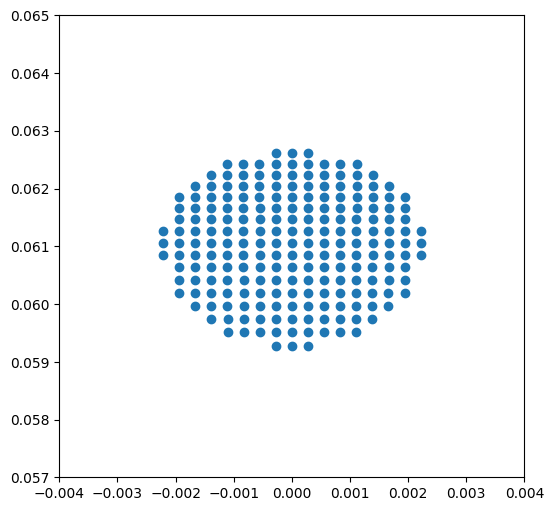

In [333]:
plt.figure(figsize=(6,6))
plt.scatter(IP_array_z,IP_array_r)
plt.xlim(-0.003-0.001,0.003+0.001)
plt.ylim(0.058-0.001,0.064+0.001)

(0.05427795359064439, 0.06927795359064438)

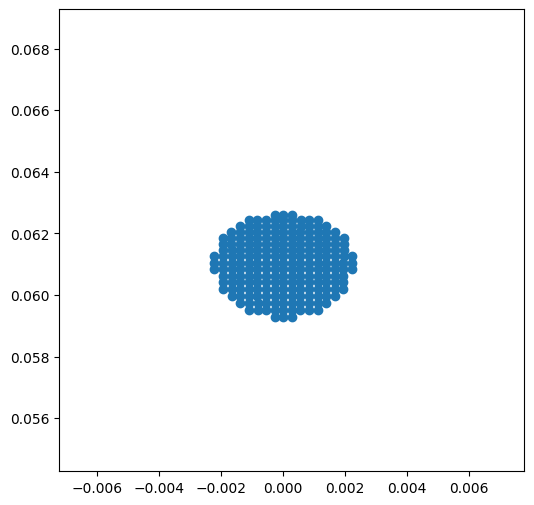

In [323]:
plt.figure(figsize=(6,6))
plt.scatter(Z_data,IP_dist_val)
min_z = np.min(Z_data)
max_z = np.max(Z_data)
min_r = np.min(IP_dist_val)
max_r = np.max(IP_dist_val)
delta = max_z-min_z
plt.xlim(min_z-0.005,min_z+0.010)
plt.ylim(min_r-0.005,min_r+0.010)
#plt.ylim(IP_dist_val[-100]-0.5*delta-0.0005,IP_dist_val[-100]+0.5*delta+0.0005)

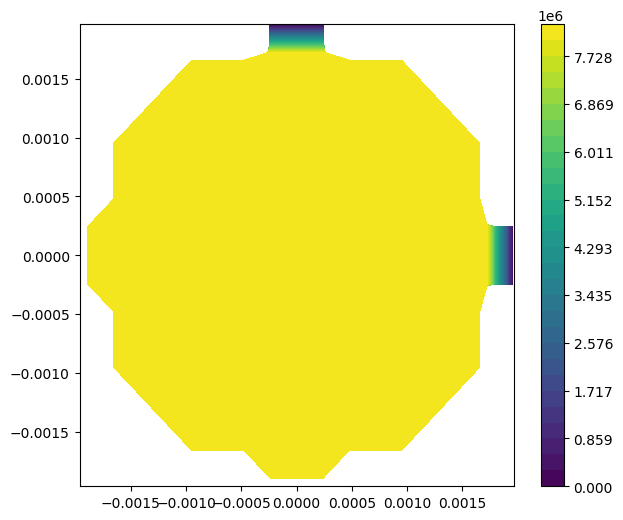

In [334]:
#loop for finding the area occupied by each particle
i = 0
j = 0
for i in range(0,len_m):
    for j in range(0,len_n):
        #j is z
        #i is y
        if target_array_true[j,i] == 1:
            deltay1 = target_array_y[j,i+1]-target_array_y[j,i]
            deltaz1 = target_array_z[j,i+1]-target_array_z[j,i]
            deltar1 = [deltaz1,deltay1]

            deltay2 = target_array_y[j+1,i]-target_array_y[j,i]
            deltaz2 = target_array_z[j+1,i]-target_array_z[j,i]
            deltar2 = [deltaz2,deltay2]

            deltay3 = target_array_y[j,i-1]-target_array_y[j,i]
            deltaz3 = target_array_z[j,i-1]-target_array_z[j,i]
            deltar3 = [deltaz3,deltay3]

            deltay4 = target_array_y[j-1,i]-target_array_y[j,i]
            deltaz4 = target_array_z[j-1,i]-target_array_z[j,i]
            deltar4 = [deltaz4,deltay4]
            
            scale1 = target_array_true[j,i+1]*target_array_true[j+1,i]
            scale2 = target_array_true[j+1,i]*target_array_true[j,i-1]
            scale3 = target_array_true[j,i-1]*target_array_true[j-1,i]
            scale4 = target_array_true[j-1,i]*target_array_true[j,i+1]

            area1 = scale1*np.abs(np.cross(deltar1,deltar2))
            area2 = scale2*np.abs(np.cross(deltar2,deltar3))
            area3 = scale3*np.abs(np.cross(deltar3,deltar4))
            area4 = scale4*np.abs(np.cross(deltar4,deltar1))

            area = 2*(area1+area2+area3+area4)
            scale = scale1+scale2+scale3+scale4

            if area == 0:
                area = 1

            area_density_function[j,i] = scale/area
        j = j+1
    i = i+1


#plt.imshow((target_array_true))
#plt.imshow((area_density_function))
#plt.colorbar()

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(target_array_z, target_array_y, area_density_function, cmap='viridis') # 'viridis' is a colormap

contourf_ = plt.figure(figsize = (7,6))
adf_max = np.max(area_density_function)
contourf_ = plt.contourf(target_array_z, target_array_y, area_density_function,np.linspace(0,adf_max,30), cmap='viridis')
plt.colorbar(contourf_)

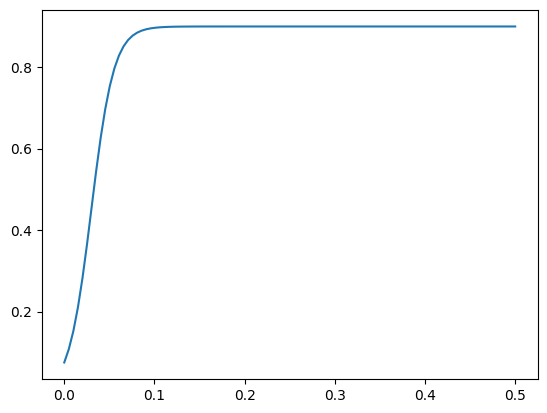

In [206]:
Baxes = np.linspace(0,0.5,100)
#Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.05)))
Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.030)))

IPradius = 0.14
IPcenter = np.array([0.06,-0.12])

E = 500

solidangle = 0.002
N_particles = 51
thetarange = math.pi*np.linspace(-solidangle,solidangle,N_particles)

plt.plot(Baxes,Bdata)

-0.6409829640286238


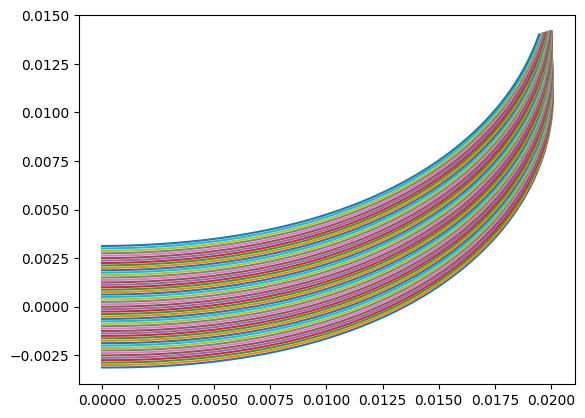

In [207]:
#plt.figure(figsize = (10,10))

X_data = []
Y_data = []
Z_data = []

for theta in thetarange:
    X, Y, Z = track_particle_2D(
        E,
        B_data = Bdata,
        B_axes = Baxes,
        theta_0 = theta,
        theta_z = (1/32)*math.pi,
        d_tcc = 0.5,
        delta_d = 0.000025,
        nonuniform_B = True,
        uniform_B = 1,
        charge_mass_ratio = 9.58e7,
        charge_in_e = 1,
        plate = 'curved',
        IP_radius = IPradius,
        IP_center = IPcenter,
        )

    plt.plot(X,Y)
    X_data.append(X[-1])
    Y_data.append(Y[-1])

XIP_data = np.array(X_data-IPcenter[0])
YIP_data = np.array(Y_data-IPcenter[1])

#rotate axes to calculate angle from start of IP
theta_0_IP = -math.pi + math.atan(np.sqrt(IPradius**2-(IPcenter[0])**2)/IPcenter[0])
print(theta_0_IP/math.pi)
Xprime = math.cos(theta_0_IP)*XIP_data-math.sin(theta_0_IP)*YIP_data
Yprime = math.sin(theta_0_IP)*XIP_data+math.cos(theta_0_IP)*YIP_data

#using atan to find angle from start of IP
theta_IP_prime = np.zeros(len(Yprime)) 
for i in range(len(Yprime)):
    theta_IP_prime[i] = -math.atan(Yprime[i]/Xprime[i])

#now we can find the distance along the IP
IP_dist_val = theta_IP_prime*IPradius